# Part 1: JAX neural net basics

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/neural_net_basics.ipynb)

## Example: A simple neural network with Flax

We'll start with a very quick example of what it looks like to use JAX with the [Flax](https://flax.readthedocs.io) framework to define and train a very simple neural network to recognize hand-written digits.

### Loading the data

JAX can work with a variety of data loaders, including [Grain](https://github.com/google/grain), [TensorFlow Datasets](https://github.com/tensorflow/datasets) and [TorchData](https://github.com/pytorch/data), but for simplicity this example uses the well-known [scikit-learn `digits`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

print(f"{digits.data.shape=}")
print(f"{digits.target.shape=}")

digits.data.shape=(1797, 64)
digits.target.shape=(1797,)


This dataset consists of `8x8` pixelated images of hand-written digits and their corresponding labels. Let’s visualize a handful of them with [`matplotlib`](https://matplotlib.org/stable/tutorials/index):

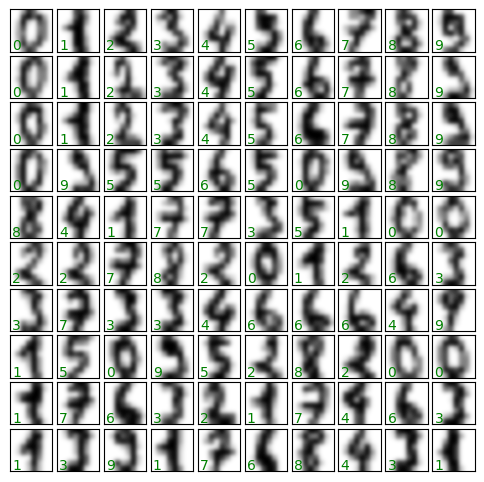

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='gaussian')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')

Next, we split the dataset into a training and testing set, and convert these splits into [`jax.Array`s](https://jax.readthedocs.io/en/latest/key-concepts.html#jax-arrays-jax-array) before we feed them into the model.
We’ll use the `jax.numpy` module, which provides a familiar NumPy-style API around JAX operations:

In [3]:
from sklearn.model_selection import train_test_split
splits = train_test_split(digits.images, digits.target, random_state=0)

In [4]:
import jax.numpy as jnp
images_train, images_test, label_train, label_test = map(jnp.asarray, splits)
print(f"{images_train.shape=} {label_train.shape=}")
print(f"{images_test.shape=}  {label_test.shape=}")

images_train.shape=(1347, 8, 8) label_train.shape=(1347,)
images_test.shape=(450, 8, 8)  label_test.shape=(450,)


### Defining the Flax model

We can now use [Flax NNX](http://flax.readthedocs.io) to create a simple [feed-forward](https://en.wikipedia.org/wiki/Feedforward_neural_network) neural network - subclassing [`flax.nnx.Module`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/module.html#flax.nnx.Module) - with [`flax.nnx.Linear`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/linear.html#flax.nnx.Linear) layers with *scaled exponential linear unit* (SELU) activation function using the built-in [`flax.nnx.selu`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/activations.html#flax.nnx.selu):

In [5]:
from flax import nnx

class SimpleNN(nnx.Module):

  def __init__(self, n_features: int = 64, n_hidden: int = 100, n_targets: int = 10,
               *, rngs: nnx.Rngs):
    self.n_features = n_features
    self.layer1 = nnx.Linear(n_features, n_hidden, rngs=rngs)
    self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
    self.layer3 = nnx.Linear(n_hidden, n_targets, rngs=rngs)

  def __call__(self, x):
    x = x.reshape(x.shape[0], self.n_features) # Flatten images.
    x = nnx.selu(self.layer1(x))
    x = nnx.selu(self.layer2(x))
    x = self.layer3(x)
    return x

model = SimpleNN(rngs=nnx.Rngs(0))

nnx.display(model)  # Interactive display if penzai is installed.

### Training the model

With the `SimpleNN` model created and instantiated, we can now choose the loss function and the optimizer with the [Optax](http://optax.readthedocs.io) package, and then define the training step function. Use:
- [`optax.softmax_cross_entropy_with_integer_labels`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.losses.softmax_cross_entropy_with_integer_labels) as the loss, as the output layer will have nodes corresponding to a handwritten integer label.
- [`optax.sgd`](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.sgd) for the stochastic gradient descent optimizer.
- [`flax.nnx.Optimizer`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/training/optimizer.html) to instantiate the optimizer and set the train state.

In [6]:
import jax
import optax

optimizer = nnx.Optimizer(model, optax.sgd(learning_rate=0.05))

def loss_fun(
    model: nnx.Module,
    data: jax.Array,
    labels: jax.Array):
  logits = model(data)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=labels
  ).mean()
  return loss, logits

@nnx.jit  # JIT-compile the function
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    data: jax.Array,
    labels: jax.Array):
  loss_gradient = nnx.grad(loss_fun, has_aux=True)  # gradient transform!
  grads, logits = loss_gradient(model, data, labels)
  optimizer.update(grads)  # inplace update

Notice here the use of [`flax.nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit) and [`flax.nnx.grad`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.grad), which are [Flax NNX transformations](https://flax.readthedocs.io/en/latest/guides/transforms.html) built on `jax.jit` and `jax.grad` [transformations](https://jax.readthedocs.io/en/latest/key-concepts.html#transformations).

- `jax.jit` is a [Just-In-Time compilation transformation](https://jax.readthedocs.io/en/latest/jit-compilation.html#jit-compilation), and will cause the function to be passed to the [XLA](https://openxla.org/xla) compiler for fast repeated execution.
- `jax.grad` is a [gradient transformation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html) that uses JAX's automatic differentiation for fast optimization of large networks.

We will return to these transformations later in the tutorial.

Now that we have a training step function, let's define a training loop to repeatedly perform this training step over the training data, periodically printing the loss against the test set to monitor convergence:

In [7]:
for i in range(301):  # 300 training epochs
  train_step(model, optimizer, images_train, label_train)
  if i % 50 == 0:  # Print metrics.
    loss, _ = loss_fun(model, images_test, label_test)
    print(f"epoch {i}: loss={loss:.2f}")

epoch 0: loss=20.18
epoch 50: loss=0.21
epoch 100: loss=0.14
epoch 150: loss=0.12
epoch 200: loss=0.12
epoch 250: loss=0.11
epoch 300: loss=0.11


After 300 training epochs, our model should have converged to a target loss of around `0.10`. We can check what this implies for the accuracy of the labels for each image:

In [8]:
label_pred = model(images_test).argmax(axis=1)
num_matches = jnp.count_nonzero(label_pred == label_test)
num_total = len(label_test)
accuracy = num_matches / num_total
print(f"{num_matches} labels match out of {num_total}:"
      f" accuracy = {num_matches/num_total:%}")

433 labels match out of 450: accuracy = 96.222222%


The simple feed-forward network has achieved approximately 98% accuracy on the test set.
We can do a similar visualization as above to review some examples that the model predicted correctly (in green) and incorrectly (in red):

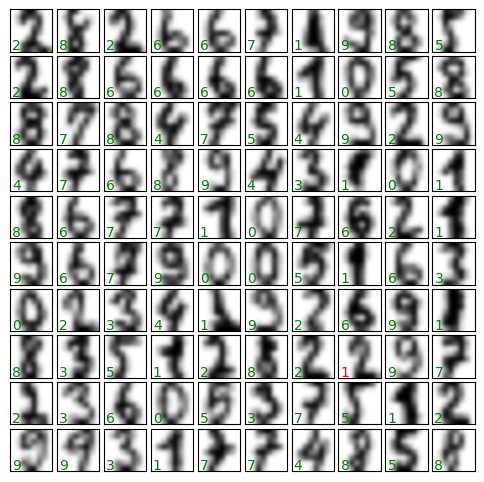

In [9]:
fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_test[i], cmap='binary', interpolation='gaussian')
    color = 'green' if label_pred[i] == label_test[i] else 'red'
    ax.text(0.05, 0.05, str(label_pred[i]), transform=ax.transAxes, color=color)

In this tutorial, we have just scraped the surface with JAX, Flax NNX, and Optax here. The Flax NNX package includes a number of useful APIs for tracking metrics during training, which are features in the [Flax MNIST tutorial](https://flax.readthedocs.io/en/latest/nnx/mnist_tutorial.html) on the Flax website.

## Key JAX features

The Flax NNX neural network API demonstrated above takes advantage of a number of [key JAX features](https://jax.readthedocs.io/en/latest/key-concepts.html), designed into the library from the ground up. In particular:

- **JAX provides a familiar NumPy-like API for array computing.**
  This means that when processing data and outputs, we can reach for APIs like [`jax.numpy.count_nonzero`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.count_nonzero.html), which mirror the familiar APIs of the NumPy package; in this case [`numpy.count_nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html).

- **JAX provides just-in-time (JIT) compilation.**
  This means that we can implement our code easily in Python, but count on fast compiled execution on CPU, GPU, and TPU backends via the [XLA](https://openxla.org/xla) compiler by wrapping the code with a simple [`jax.jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html) [transformation](https://jax.readthedocs.io/en/latest/jit-compilation.html).

- **JAX provides automatic differentiation (autodiff).**
  This means that when fitting models, `optax` and `flax` can compute closed-form gradient functions for fast optimization of models, using the [`jax.grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) [transformation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html).

- **JAX provides automatic vectorization.**
  While we didn't get to use this directly in the code before, but under the hood flax takes advantage of [JAX's vectorized map](https://jax.readthedocs.io/en/latest/automatic-vectorization.html) ([`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)) to automatically convert loss and gradient functions to efficient batch-aware functions that are just as fast as hand-written versions. This makes JAX implementations simpler and less error-prone.

We will learn more about these features through brief examples in the following sections.

### JAX NumPy interface

The foundational array computing package in Python is NumPy, and [JAX provides](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jax-vs-numpy) [a matching API](https://jax.readthedocs.io/en/latest/quickstart.html#jax-as-numpy) via the [`jax.numpy`](https://jax.readthedocs.io/en/latest/jax.numpy.html) subpackage.
Additionally, [JAX arrays](https://jax.readthedocs.io/en/latest/key-concepts.html#jax-arrays-jax-array) ([`jax.Array`](https://jax.readthedocs.io/en/latest/_autosummary/jax.Array.html#jax.Array)) behave much like NumPy arrays in their attributes, and in terms of [indexing](https://numpy.org/doc/stable/user/basics.indexing.html) and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) semantics.

In the previous example, we used Flax's built-in `flax.nnx.selu` implementation. We can also implement SeLU using JAX's NumPy API as follows:

In [10]:
import jax.numpy as jnp

def selu(x, alpha=1.67, lam=1.05):
  return lam * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
print(selu(x))

[0.        1.05      2.1       3.1499999 4.2      ]


Despite the broad similarities, be aware that JAX does have some well-motivated differences from NumPy that you can read about in [🔪 JAX – The Sharp Bits 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) on the JAX site.

### Just-in-time compilation

As mentioned before, JAX is built on the [XLA](https://openxla.org/xla) compiler, and allows sequences of operations to be just-in-time (JIT) compiled using the [`jax.jit` transformation](https://jax.readthedocs.io/en/latest/jit-compilation.html).
In the neural network example above, we used the [similar](https://flax.readthedocs.io/en/latest/guides/transforms.html) [`flax.nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit) transform, which has some special handling for Flax NNX objects for speed in neural network training.

Returning to the previously defined `selu` function in JAX, we can create a `jax.jit`-compiled version this way:

In [11]:
import jax
selu_jit = jax.jit(selu)

`selu_jit` is now a compiled version of the original function, which returns the same result to typical floating-point precision:

In [12]:
x = jnp.arange(1E6)
jnp.allclose(selu(x), selu_jit(x))  # results match

Array(True, dtype=bool)

We can use IPython's `%timeit` magic to observe the speedup (note the use of [`jax.block_until_ready()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.block_until_ready.html#jax.block_until_ready), which we need to use to account for JAX's [asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html)):

In [13]:
%timeit selu(x).block_until_ready()

623 µs ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit selu_jit(x).block_until_ready()

96.1 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


For this computation, running on CPU, `jax.jit` compilation gives an order of magnitude speedup.
JAX's documentation has more discussion of JIT compilation at [Just-in-time compilation](https://jax.readthedocs.io/en/latest/jit-compilation.html).

### Automatic differentiation (autodiff)

For efficient optimization of neural network models, fast gradient computations are essential. JAX enables this via its [automatic differentiation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html) transformations like [`jax.grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html), which computes a closed-form gradient of a JAX function. In the neural network example, we used the [similar](https://flax.readthedocs.io/en/latest/guides/transforms.html) [`flax.nnx.grad`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.grad) function, which has special handling for [`flax.nnx`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/index.html) objects.

Here's how to compute the gradient of a function with `jax.grad`:

In [15]:
x = jnp.float32(-1.0)
jax.grad(selu)(x)

Array(0.64507663, dtype=float32)

We can briefly check with a finite-difference approximation that this is giving the expected value:

In [16]:
eps = 1E-3
(selu(x + eps) - selu(x)) / eps

Array(0.64539903, dtype=float32)

Importantly, the automatic differentiation approach is both more accurate and efficient than computing numerical gradients. JAX's documentation has more discussion of autodiff at [Automatic differentiation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html) and [Advanced automatic differentiation](https://jax.readthedocs.io/en/latest/advanced-autodiff.html).

### Automatic vectorization

In the training loop example earlier, we defined the loss function in terms of a single input data vector of shape `n_features` but trained the model by passing batches of data (of shape `[n_samples, n_features]`). Rather than requiring a naive and slow loop over batches in Flax and Optax internals, they instead use JAX's [automatic vectorization](https://jax.readthedocs.io/en/latest/automatic-vectorization.html) via the [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) transformation to construct a batched version of the kernel automatically.

Consider a simple loss function that looks like this:

In [17]:
def loss(x: jax.Array, x0: jax.Array):
  return jnp.sum((x - x0) ** 2)

We can evaluate it on a single data vector this way:

In [18]:
x = jnp.arange(3.)
x0 = jnp.ones(3)
loss(x, x0)

Array(2., dtype=float32)

But if we attempt to evaluate it on a batch of vectors, it does not correctly return a batch of 4 losses:

In [19]:
batched_x = jnp.arange(12).reshape(4, 3)  # batch of 4 vectors
loss(batched_x, x0)  # wrong!

Array(386., dtype=float32)

The problem is that this loss function is not batch-aware. Without automatic vectorization, there are two ways we can address this:

1. Re-write our loss function by hand to operate on batched data; however, as functions become more complicated, this becomes difficult and error-prone.
2. Naively loop over unbatched calls to our original function. However, this is easy to code, but can be slow because it doesn't take advantage of vectorized compute.

The [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) [transformation](https://jax.readthedocs.io/en/latest/automatic-vectorization.html) offers a third way: it automatically transforms our original function into a batch-aware version, so we get the speed of option 1 with the ease of option 2:

In [20]:
loss_batched = jax.vmap(loss, in_axes=(0, None))  # batch x over axis 0, do not batch x0
loss_batched(batched_x, x0)

Array([  2.,  29., 110., 245.], dtype=float32)

In the neural network example earlier, both `flax` and `optax` make use of JAX's `vmap` to allow for efficient batched computations over our unbatched loss function.

JAX's documentation has more discussion of automatic vectorization at [Automatic vectorization](https://jax.readthedocs.io/en/latest/automatic-vectorization.html).